<a href="https://colab.research.google.com/github/mariannaflores/final_eml/blob/main/proyecto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Proyecto Final - Machine Learning Models
## MODELO DE PREDICCION DE NOMBRE SEGUN COLOR DE PINTURA DE UNAS

#### LIBRERIAS

In [1]:
pip install category_encoders

     |████████████████████████████████| 81kB 2.8MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#Preparacion de variables
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

#Modelos de neural networks
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2

from keras.layers import Add, Activation, Lambda

from keras.layers import Concatenate, Dense, Dropout

#### UPLOAD DATASET

In [3]:
#df = pd.read_csv('/Users/maria/OneDrive/Documentos/mle_laboratorios/Final/final_eml/dataset.csv')
#df.head()

from google.colab import files
uploaded = files.upload()

Saving dataset.csv to dataset.csv


In [4]:
import io
df = pd.read_csv(io.BytesIO(uploaded['dataset.csv']))

#### PREPARACION COLUMNA CODIGO RGB

In [5]:
codigo = df["rgb"]

remove = ['rgb']
remove2 = ['(']
remove3 = [')']

for i in remove:
    s1 = codigo.str.replace(i, '')

for j in remove2:
    s2 = s1.str.replace(j, '')


for k in remove3:
    s3 = s2.str.replace(k, '')

colores = s3.str.split(",", n = 2, expand = True)
colores.head()

,0,1,2
0,244,225,225
1,250,251,251
2,245,241,241
3,247,137,137
4,240,228,228


In [6]:
df = df.drop(['rgb'], axis=1)
df = pd.concat([df, colores], axis=1)
df = df.rename({0:"r", 1:"g", 2:"b"}, axis='columns')

In [7]:
df['index'] = df.index

#### ENCODING VARIABLES CATEGORICAS

In [8]:
ce_ord = ce.OrdinalEncoder(cols = ['type', 'category', 'marca'])
df = ce_ord.fit_transform(df)
df.head()

,name,type,score,raitings,hex,category,marca,r,g,b,index
0,sheer luck,1,5.0,3.0,#f4e1e8,1,1,244,225,225,0
1,always transparent,2,0.0,0.0,#fafbf8,1,1,250,251,251,1
2,tuck it in my tux,1,3.4,15.0,#f5f1ee,1,1,245,241,241,2
3,desk mani,2,0.0,0.0,#f78963,1,1,247,137,137,3
4,marshmallow,1,4.4,83.0,#f1e6e3,1,1,240,228,228,4


### PESOS PARA VALUAR MATRIZ POR RATING Y POR COLOR

In [9]:
m=df['raitings'].quantile(0.9)
C=df['score'].mean()

def weighted_rating(x, m=m, C=C):
    v = x['raitings']
    R = x['score']
    return (v/(v+m) * R) + (m/(m+v) * C)

df['weight'] = df.apply(weighted_rating, axis=1)
df.head()

,name,type,score,raitings,hex,category,marca,r,g,b,index,weight
0,sheer luck,1,5.0,3.0,#f4e1e8,1,1,244,225,225,0,3.718163
1,always transparent,2,0.0,0.0,#fafbf8,1,1,250,251,251,1,3.680792
2,tuck it in my tux,1,3.4,15.0,#f5f1ee,1,1,245,241,241,2,3.645068
3,desk mani,2,0.0,0.0,#f78963,1,1,247,137,137,3,3.680792
4,marshmallow,1,4.4,83.0,#f1e6e3,1,1,240,228,228,4,4.001902


In [10]:
df['r'] = df['r'].astype(int)
df['g'] = df['g'].astype(int)
df['b'] = df['b'].astype(int)

df['color'] = df['r'] + df['g']*100 + df['b']*10000

### SEPARACION DE VARIABLES X Y Y 

In [14]:
min1 = min(df["weight"])
max1 = max(df["weight"])

x1 = df[["type", "index"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y1 = df["weight"].apply(lambda x: (x - min1) / (max1 - min1)).values

x_train1, x_cv1, x_test1 = np.split(x1, 
                       [int(.3333*len(x1)), int(.6666*len(x1))])
y_train1, y_cv1, y_test1 = np.split(y1, 
                       [int(.3333*len(y1)), int(.666*len(y1))])

y_test1 = y_test1[0:336]
x_cv1 = x_cv1[0:336]
x_test1 = x_test1[0:336]

print(y_train1.shape, y_cv1.shape, y_test1.shape)
print(x_train1.shape, x_cv1.shape, x_test1.shape)

(336,) (336,) (336,)
(336, 2) (336, 2) (336, 2)


In [15]:
min2 = min(df["color"])
max2 = max(df["color"])

x2 = df[["type", "index"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y2 = df["color"].apply(lambda x: (x - min2) / (max2 - min2)).values

x_train2, x_cv2, x_test2 = np.split(x2, 
                       [int(.3333*len(x2)), int(.6666*len(x2))])
y_train2, y_cv2, y_test2 = np.split(y2, 
                       [int(.3333*len(y2)), int(.666*len(y2))])

y_test2 = y_test2[0:336]
x_cv2 = x_cv2[0:336]
x_test2 = x_test2[0:336]

print(y_train2.shape, y_cv2.shape, y_test2.shape)
print(x_train2.shape, x_cv2.shape, x_test2.shape)

(336,) (336,) (336,)
(336, 2) (336, 2) (336, 2)


### MODELO DE RECOMENDACION PESO DE RATINGS

In [16]:
n_factors = 25
n_users = df['type'].nunique()+1
n_movies = df['index'].nunique()

In [17]:
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x

In [18]:
def RecommenderV1(n_users, n_movies, n_factors):
    user = Input(shape=(1,))
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    u = Reshape((n_factors,))(u)
    
    movie = Input(shape=(1,))
    m = Embedding(n_movies, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(movie)
    m = Reshape((n_factors,))(m)
    
    x = Dot(axes=1)([u, m])
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [19]:
modelo1 = RecommenderV1(n_users, n_movies, n_factors)
modelo1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 25)        175         input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 25)        25250       input_2[0][0]                    
______________________________________________________________________________________________

In [20]:
x_train_array1 = [x_train1[:, 0], x_train1[:, 1]]
x_cv_array1 = [x_cv1[:, 0], x_cv1[:, 1]]

x_train_array2 = [x_train2[:, 0], x_train2[:, 1]]
x_cv_array2 = [x_cv2[:, 0], x_cv2[:, 1]]

In [21]:
history = modelo1.fit(x=x_train_array1, y=y_train1, batch_size=100, epochs=50,
                    verbose=1, validation_data=(x_cv_array1, y_cv1))

Epoch 1/50
4/4 [==============================] - 1s 186ms/step - loss: 0.1913 - val_loss: 0.2044
Epoch 2/50
4/4 [==============================] - 0s 17ms/step - loss: 0.1680 - val_loss: 0.2039
Epoch 3/50
4/4 [==============================] - 0s 23ms/step - loss: 0.1563 - val_loss: 0.2034
Epoch 4/50
4/4 [==============================] - 0s 20ms/step - loss: 0.1405 - val_loss: 0.2029
Epoch 5/50
4/4 [==============================] - 0s 17ms/step - loss: 0.1228 - val_loss: 0.2024
Epoch 6/50
4/4 [==============================] - 0s 22ms/step - loss: 0.1117 - val_loss: 0.2018
Epoch 7/50
4/4 [==============================] - 0s 20ms/step - loss: 0.0959 - val_loss: 0.2013
Epoch 8/50
4/4 [==============================] - 0s 19ms/step - loss: 0.0854 - val_loss: 0.2007
Epoch 9/50
4/4 [==============================] - 0s 19ms/step - loss: 0.0782 - val_loss: 0.2001
Epoch 10/50
4/4 [==============================] - 0s 18ms/step - loss: 0.0670 - val_loss: 0.1996
Epoch 11/50
4/4 [===========

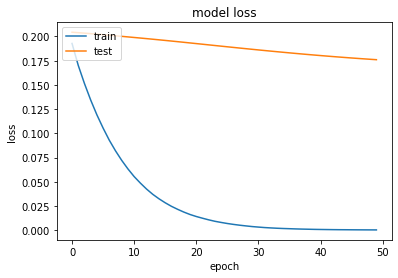

In [22]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [23]:
def RecommenderV2(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    ub = EmbeddingLayer(n_users, 1)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    mb = EmbeddingLayer(n_movies, 1)(movie)
    x = Dot(axes=1)([u, m])
    x = Add()([x, ub, mb])
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [24]:
modelo2 = RecommenderV2(n_users, n_movies, n_factors, min1, max1)
modelo2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 25)        175         input_3[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 25)        25250       input_4[0][0]                    
____________________________________________________________________________________________

In [25]:
history = modelo2.fit(x=x_train_array1, y=y_train1, batch_size=64, epochs=50,
                    verbose=1, validation_data=(x_cv_array1, y_cv1))

Epoch 1/50
6/6 [==============================] - 1s 54ms/step - loss: 11.7979 - val_loss: 12.5208
Epoch 2/50
6/6 [==============================] - 0s 12ms/step - loss: 11.8045 - val_loss: 12.5100
Epoch 3/50
6/6 [==============================] - 0s 13ms/step - loss: 11.7531 - val_loss: 12.4992
Epoch 4/50
6/6 [==============================] - 0s 13ms/step - loss: 11.6452 - val_loss: 12.4883
Epoch 5/50
6/6 [==============================] - 0s 12ms/step - loss: 11.5359 - val_loss: 12.4774
Epoch 6/50
6/6 [==============================] - 0s 11ms/step - loss: 11.5129 - val_loss: 12.4665
Epoch 7/50
6/6 [==============================] - 0s 15ms/step - loss: 11.4499 - val_loss: 12.4555
Epoch 8/50
6/6 [==============================] - 0s 13ms/step - loss: 11.3851 - val_loss: 12.4446
Epoch 9/50
6/6 [==============================] - 0s 14ms/step - loss: 11.3858 - val_loss: 12.4337
Epoch 10/50
6/6 [==============================] - 0s 13ms/step - loss: 11.3214 - val_loss: 12.4229
Epoch 11/

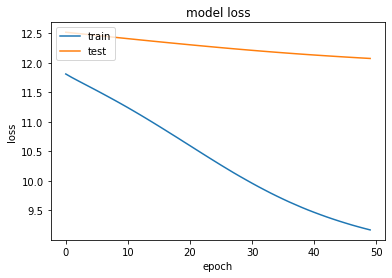

In [26]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [27]:
def RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    
    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [28]:
modelo3 = RecommenderNet(n_users, n_movies, n_factors, min1, max1)
modelo3.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 25)        175         input_5[0][0]                    
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1, 25)        25250       input_6[0][0]                    
____________________________________________________________________________________________

In [29]:
history = modelo3.fit(x=x_train_array1, y=y_train1, batch_size=64, epochs=50,
                    verbose=1, validation_data=(x_cv_array1, y_cv1))

Epoch 1/50
6/6 [==============================] - 1s 46ms/step - loss: 11.9025 - val_loss: 11.5592
Epoch 2/50
6/6 [==============================] - 0s 11ms/step - loss: 11.3244 - val_loss: 11.2273
Epoch 3/50
6/6 [==============================] - 0s 11ms/step - loss: 11.0249 - val_loss: 10.9280
Epoch 4/50
6/6 [==============================] - 0s 12ms/step - loss: 10.9270 - val_loss: 10.6604
Epoch 5/50
6/6 [==============================] - 0s 11ms/step - loss: 10.5401 - val_loss: 10.4302
Epoch 6/50
6/6 [==============================] - 0s 13ms/step - loss: 10.3006 - val_loss: 10.2291
Epoch 7/50
6/6 [==============================] - 0s 12ms/step - loss: 10.1260 - val_loss: 10.0350
Epoch 8/50
6/6 [==============================] - 0s 12ms/step - loss: 9.9012 - val_loss: 9.8589
Epoch 9/50
6/6 [==============================] - 0s 11ms/step - loss: 9.7380 - val_loss: 9.7170
Epoch 10/50
6/6 [==============================] - 0s 12ms/step - loss: 9.4577 - val_loss: 9.6109
Epoch 11/50
6/6

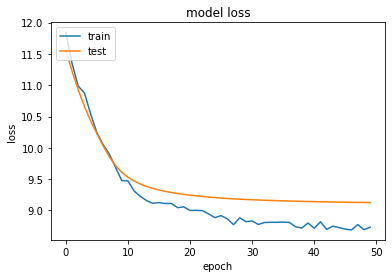

In [30]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [53]:
print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

array([[3.3085902],
       [3.3085902],
       [3.3085904],
       [3.3085897],
       [3.3085902],
       [3.3085895],
       [3.308589 ],
       [3.3085895],
       [3.30859  ],
       [3.735831 ],
       [3.7368023],
       [3.7371562],
       [3.7378998],
       [3.7366953],
       [3.7373548],
       [3.7374213],
       [3.7358027],
       [3.7366228],
       [3.3085892],
       [3.30859  ],
       [3.3085897],
       [3.3085887],
       [3.3085907],
       [3.3085887],
       [3.3085897],
       [3.3085895],
       [3.308589 ],
       [3.3085902],
       [3.3085904],
       [3.7372346],
       [3.7364228],
       [3.7366748],
       [3.7374601],
       [3.736433 ],
       [3.7365992],
       [3.7367783],
       [3.7373197],
       [3.737061 ],
       [3.7377877],
       [3.7363405],
       [3.7362936],
       [3.3085897],
       [3.3085895],
       [3.3085902],
       [3.3085907],
       [3.3085902],
       [3.3085897],
       [3.3085892],
       [3.3085897],
       [3.3085902],


In [38]:
x_cv1

array([[  1, 336],
       [  1, 337],
       [  1, 338],
       [  1, 339],
       [  1, 340],
       [  1, 341],
       [  3, 342],
       [  1, 343],
       [  3, 344],
       [  1, 345],
       [  1, 346],
       [  3, 347],
       [  1, 348],
       [  1, 349],
       [  1, 350],
       [  1, 351],
       [  1, 352],
       [  1, 353],
       [  3, 354],
       [  3, 355],
       [  3, 356],
       [  1, 357],
       [  1, 358],
       [  1, 359],
       [  1, 360],
       [  1, 361],
       [  1, 362],
       [  1, 363],
       [  1, 364],
       [  1, 365],
       [  1, 366],
       [  1, 367],
       [  1, 368],
       [  3, 369],
       [  1, 370],
       [  1, 371],
       [  1, 372],
       [  1, 373],
       [  1, 374],
       [  3, 375],
       [  1, 376],
       [  3, 377],
       [  3, 378],
       [  1, 379],
       [  1, 380],
       [  1, 381],
       [  1, 382],
       [  1, 383],
       [  3, 384],
       [  1, 385],
       [  1, 386],
       [  1, 387],
       [  1,

In [31]:
history = modelo3.fit(x=x_train_array2, y=y_train2, batch_size=64, epochs=50,
                    verbose=1, validation_data=(x_cv_array2, y_cv2))

Epoch 1/50
6/6 [==============================] - 0s 23ms/step - loss: 8.2945 - val_loss: 8.5905
Epoch 2/50
6/6 [==============================] - 0s 11ms/step - loss: 8.2936 - val_loss: 8.5895
Epoch 3/50
6/6 [==============================] - 0s 11ms/step - loss: 8.2861 - val_loss: 8.5885
Epoch 4/50
6/6 [==============================] - 0s 11ms/step - loss: 8.3044 - val_loss: 8.5876
Epoch 5/50
6/6 [==============================] - 0s 12ms/step - loss: 8.3178 - val_loss: 8.5868
Epoch 6/50
6/6 [==============================] - 0s 12ms/step - loss: 8.3097 - val_loss: 8.5857
Epoch 7/50
6/6 [==============================] - 0s 11ms/step - loss: 8.2733 - val_loss: 8.5847
Epoch 8/50
6/6 [==============================] - 0s 13ms/step - loss: 8.2707 - val_loss: 8.5838
Epoch 9/50
6/6 [==============================] - 0s 11ms/step - loss: 8.2577 - val_loss: 8.5829
Epoch 10/50
6/6 [==============================] - 0s 12ms/step - loss: 8.2863 - val_loss: 8.5818
Epoch 11/50
6/6 [============

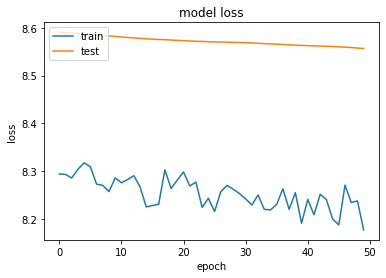

In [32]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()